# 1.13d: Bounding Hypersphere Dynamics and Flux Analysis

**Goal:** Look for **precursors to structure formation** by analyzing the bounding hypersphere of untrained tokens.

## The Big Question

We know:
- **1.12b (supermassive BH):** Untrained tokens stay frozen together (no fragmentation mechanism discovered yet)
- **1.12a (default init):** Probably won't show lattice structure in final state

But maybe structure formation is **gradual**. Maybe untrained tokens get pushed together during training, even if they don't form discrete lattice structures within 10k steps.

## What We'll Measure

### 1. Bounding Hypersphere

At each timestep, for untrained tokens:
- **Centroid:** $\mathbf{c}(t) = \frac{1}{N_{\text{untrained}}} \sum_{i \in \text{untrained}} \mathbf{W}_i(t)$
- **Radius:** $R(t) = \max_{i \in \text{untrained}} \|\mathbf{W}_i(t) - \mathbf{c}(t)\|$

This defines a hypersphere centered at $\mathbf{c}(t)$ with radius $R(t)$ that contains all untrained tokens.

**What it tells us:**
- $R(t)$ shrinking → untrained tokens converging (potential structure formation)
- $R(t)$ constant → no convergence
- $R(t)$ growing → untrained tokens spreading apart

### 2. Flux Through Surface

At each timestep, count how many **trained** tokens are inside the bounding hypersphere:

$$N_{\text{inside}}(t) = |\{i \in \text{trained} : \|\mathbf{W}_i(t) - \mathbf{c}(t)\| < R(t)\}|$$

Then compute flux:

$$\Phi(t) = N_{\text{inside}}(t+1) - N_{\text{inside}}(t)$$

**What it tells us:**
- $\Phi > 0$: Trained tokens **entering** the untrained region (weird!)
- $\Phi < 0$: Trained tokens **escaping** from the untrained region (expected)
- $\Phi = 0$: No flow across boundary

### 3. Clustering Analysis (Bonus)

Do untrained tokens split into multiple clusters over time?

- Run k-means with k=1,2,3,4,5
- Compute silhouette score for each k
- If k>1 has better score → fragmentation happening

## Expected Results

**For 1.12a (default init):**
- R(t) probably constant or slightly growing (no convergence)
- Negative flux (trained tokens escaping)
- No clustering (k=1 always best)

**For 1.12b (supermassive BH):**
- R(t) starts at 0, stays near 0 (tokens frozen together)
- Negative flux (trained tokens escaping from BH)
- No clustering (all tokens at same point)

If we see anything different—R(t) shrinking, positive flux, clustering—that's evidence for structure formation!

## Parameters

In [2]:
# Training data to analyze
TRAINING_DATA_PATH = "../tensors/Lil_Gatsby/1.12a_training_data_default_init_50000.safetensors"

# Corpus path (to identify trained vs untrained tokens)
CORPUS_PATH = "../data/gatsby_clean.txt"

# Analysis parameters
MAX_K_CLUSTERS = 5  # For k-means clustering analysis

# Visualization
PLOT_DPI = 150

## Imports

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from safetensors.torch import load_file
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("✓ Imports complete")

✓ Imports complete


## Load Training Data

In [4]:
print(f"Loading training data: {TRAINING_DATA_PATH}\n")

data = load_file(TRAINING_DATA_PATH)
embeddings = data['embeddings'].float()  # (n_steps, vocab_size, hidden_dim)

n_steps, vocab_size, hidden_dim = embeddings.shape

print(f"✓ Loaded training data")
print(f"  Shape: {embeddings.shape}")
print(f"  Steps: {n_steps:,}")
print(f"  Vocab: {vocab_size}")
print(f"  Hidden dim: {hidden_dim}")

Loading training data: ../tensors/Lil_Gatsby/1.12a_training_data_default_init_50000.safetensors

✓ Loaded training data
  Shape: torch.Size([50001, 128, 64])
  Steps: 50,001
  Vocab: 128
  Hidden dim: 64


## Identify Trained vs Untrained Tokens

In [5]:
print(f"\nAnalyzing corpus: {CORPUS_PATH}\n")

# Read corpus and find which tokens appear
with open(CORPUS_PATH, 'r', encoding='ascii') as f:
    corpus_text = f.read()

corpus_bytes = corpus_text.encode('ascii')
trained_tokens = sorted(set(corpus_bytes))
untrained_tokens = sorted(set(range(vocab_size)) - set(trained_tokens))

print(f"✓ Identified token usage")
print(f"  Trained: {len(trained_tokens)} tokens")
print(f"  Untrained: {len(untrained_tokens)} tokens")

trained_indices = torch.tensor(trained_tokens, dtype=torch.long)
untrained_indices = torch.tensor(untrained_tokens, dtype=torch.long)


Analyzing corpus: ../data/gatsby_clean.txt

✓ Identified token usage
  Trained: 79 tokens
  Untrained: 49 tokens


## Part 1: Bounding Hypersphere Dynamics

For each timestep:
1. Compute centroid of untrained tokens
2. Compute radius (max distance from centroid)
3. Track how R(t) evolves

In [6]:
print(f"\nComputing bounding hypersphere for untrained tokens...\n")

# Storage
centroids = torch.zeros(n_steps, hidden_dim)
radii = torch.zeros(n_steps)
centroid_norms = torch.zeros(n_steps)

# For each timestep
for t in range(n_steps):
    # Get untrained token positions at this timestep
    untrained_positions = embeddings[t, untrained_indices, :]  # (n_untrained, hidden_dim)
    
    # Compute centroid
    centroid = untrained_positions.mean(dim=0)  # (hidden_dim,)
    centroids[t] = centroid
    centroid_norms[t] = torch.norm(centroid)
    
    # Compute radius (max distance from centroid)
    distances = torch.norm(untrained_positions - centroid, p=2, dim=1)
    radius = distances.max()
    radii[t] = radius
    
    if t % 1000 == 0:
        print(f"  Step {t:5d}: centroid norm = {centroid_norms[t]:.6f}, radius = {radii[t]:.6f}")

print(f"\n✓ Computed bounding hypersphere for all {n_steps:,} steps")
print(f"  Initial radius: {radii[0]:.6f}")
print(f"  Final radius: {radii[-1]:.6f}")
print(f"  Change: {(radii[-1] - radii[0]).item():.6f} ({100 * (radii[-1] - radii[0]) / radii[0]:.1f}%)")


Computing bounding hypersphere for untrained tokens...

  Step     0: centroid norm = 0.023469, radius = 0.191929
  Step  1000: centroid norm = 0.596278, radius = 0.301133
  Step  2000: centroid norm = 0.587837, radius = 0.361521
  Step  3000: centroid norm = 0.575060, radius = 0.402754
  Step  4000: centroid norm = 0.564706, radius = 0.468048
  Step  5000: centroid norm = 0.555848, radius = 0.512193
  Step  6000: centroid norm = 0.551790, radius = 0.521514
  Step  7000: centroid norm = 0.543839, radius = 0.544438
  Step  8000: centroid norm = 0.538056, radius = 0.551138
  Step  9000: centroid norm = 0.534116, radius = 0.562806
  Step 10000: centroid norm = 0.531870, radius = 0.563478
  Step 11000: centroid norm = 0.528948, radius = 0.565490
  Step 12000: centroid norm = 0.524028, radius = 0.570801
  Step 13000: centroid norm = 0.521988, radius = 0.582119
  Step 14000: centroid norm = 0.521521, radius = 0.584587
  Step 15000: centroid norm = 0.520409, radius = 0.589926
  Step 16000: c

## Part 2: Flux Analysis

Count trained tokens inside the bounding hypersphere at each timestep.

In [8]:
print(f"\nComputing flux through bounding surface...\n")

# Storage
n_inside = torch.zeros(n_steps, dtype=torch.long)

# For each timestep
for t in range(n_steps):
    # Get trained token positions at this timestep
    trained_positions = embeddings[t, trained_indices, :]  # (n_trained, hidden_dim)
    
    # Compute distances from untrained centroid
    distances = torch.norm(trained_positions - centroids[t], p=2, dim=1)
    
    # Count how many are inside radius
    inside = (distances < radii[t]).sum()
    n_inside[t] = inside
    
    if t % 1000 == 0:
        print(f"  Step {t:5d}: {inside}/{len(trained_tokens)} trained tokens inside")

# Compute flux (change in count)
flux = n_inside[1:] - n_inside[:-1]  # (n_steps-1,)

print(f"\n✓ Computed flux for all steps")
print(f"  Initial count: {n_inside[0]} trained tokens inside")
print(f"  Final count: {n_inside[-1]} trained tokens inside")
print(f"  Net change: {(n_inside[-1] - n_inside[0]).item()} tokens")
print(f"  Mean flux: {flux.float().mean().item():.3f} tokens/step")
print(f"  Total outflow events: {(flux < 0).sum().item()}")
print(f"  Total inflow events: {(flux > 0).sum().item()}")


Computing flux through bounding surface...

  Step     0: 77/79 trained tokens inside
  Step  1000: 8/79 trained tokens inside
  Step  2000: 8/79 trained tokens inside
  Step  3000: 7/79 trained tokens inside
  Step  4000: 10/79 trained tokens inside
  Step  5000: 11/79 trained tokens inside
  Step  6000: 10/79 trained tokens inside
  Step  7000: 10/79 trained tokens inside
  Step  8000: 10/79 trained tokens inside
  Step  9000: 10/79 trained tokens inside
  Step 10000: 10/79 trained tokens inside
  Step 11000: 10/79 trained tokens inside
  Step 12000: 10/79 trained tokens inside
  Step 13000: 10/79 trained tokens inside
  Step 14000: 10/79 trained tokens inside
  Step 15000: 10/79 trained tokens inside
  Step 16000: 10/79 trained tokens inside
  Step 17000: 10/79 trained tokens inside
  Step 18000: 10/79 trained tokens inside
  Step 19000: 10/79 trained tokens inside
  Step 20000: 10/79 trained tokens inside
  Step 21000: 10/79 trained tokens inside
  Step 22000: 10/79 trained tokens

## Part 3: Clustering Analysis (Bonus)

Check if untrained tokens fragment into multiple clusters.

We'll sample a few timesteps to avoid computational cost.

In [9]:
print(f"\nClustering analysis (k-means)...\n")

# Sample timesteps to analyze
sample_steps = [0, 100, 1000, 5000, n_steps-1]

clustering_results = {}

for step in sample_steps:
    print(f"Step {step}:")
    
    # Get untrained token positions
    positions = embeddings[step, untrained_indices, :].numpy()
    
    # Try different k values
    silhouette_scores = {}
    
    for k in range(2, min(MAX_K_CLUSTERS + 1, len(untrained_tokens))):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(positions)
        
        # Compute silhouette score (higher = better clustering)
        score = silhouette_score(positions, labels)
        silhouette_scores[k] = score
    
    # Find best k
    if silhouette_scores:
        best_k = max(silhouette_scores, key=silhouette_scores.get)
        best_score = silhouette_scores[best_k]
        
        print(f"  Best k: {best_k} (silhouette = {best_score:.4f})")
        print(f"  All scores: {silhouette_scores}")
        
        clustering_results[step] = {
            'best_k': best_k,
            'best_score': best_score,
            'all_scores': silhouette_scores
        }
    else:
        print(f"  Not enough tokens for clustering (need >= 2)")
    
    print()

print(f"✓ Clustering analysis complete")


Clustering analysis (k-means)...

Step 0:
  Best k: 2 (silhouette = 0.0288)
  All scores: {2: 0.028815094381570816, 3: 0.01938958466053009, 4: 0.027838699519634247, 5: 0.01757107302546501}

Step 100:
  Best k: 2 (silhouette = 0.0310)
  All scores: {2: 0.030987652018666267, 3: 0.02160627767443657, 4: 0.025393178686499596, 5: 0.02190704643726349}

Step 1000:
  Best k: 2 (silhouette = 0.4132)
  All scores: {2: 0.4131886959075928, 3: 0.2068241983652115, 4: 0.056928735226392746, 5: 0.060786228626966476}

Step 5000:
  Best k: 2 (silhouette = 0.4997)
  All scores: {2: 0.49966707825660706, 3: 0.49276605248451233, 4: 0.4339624047279358, 5: 0.07164041697978973}

Step 50000:
  Best k: 2 (silhouette = 0.5996)
  All scores: {2: 0.5996043682098389, 3: 0.568474292755127, 4: 0.561213493347168, 5: 0.5228606462478638}

✓ Clustering analysis complete


## Visualization: Bounding Hypersphere Dynamics


Plotting bounding hypersphere dynamics...



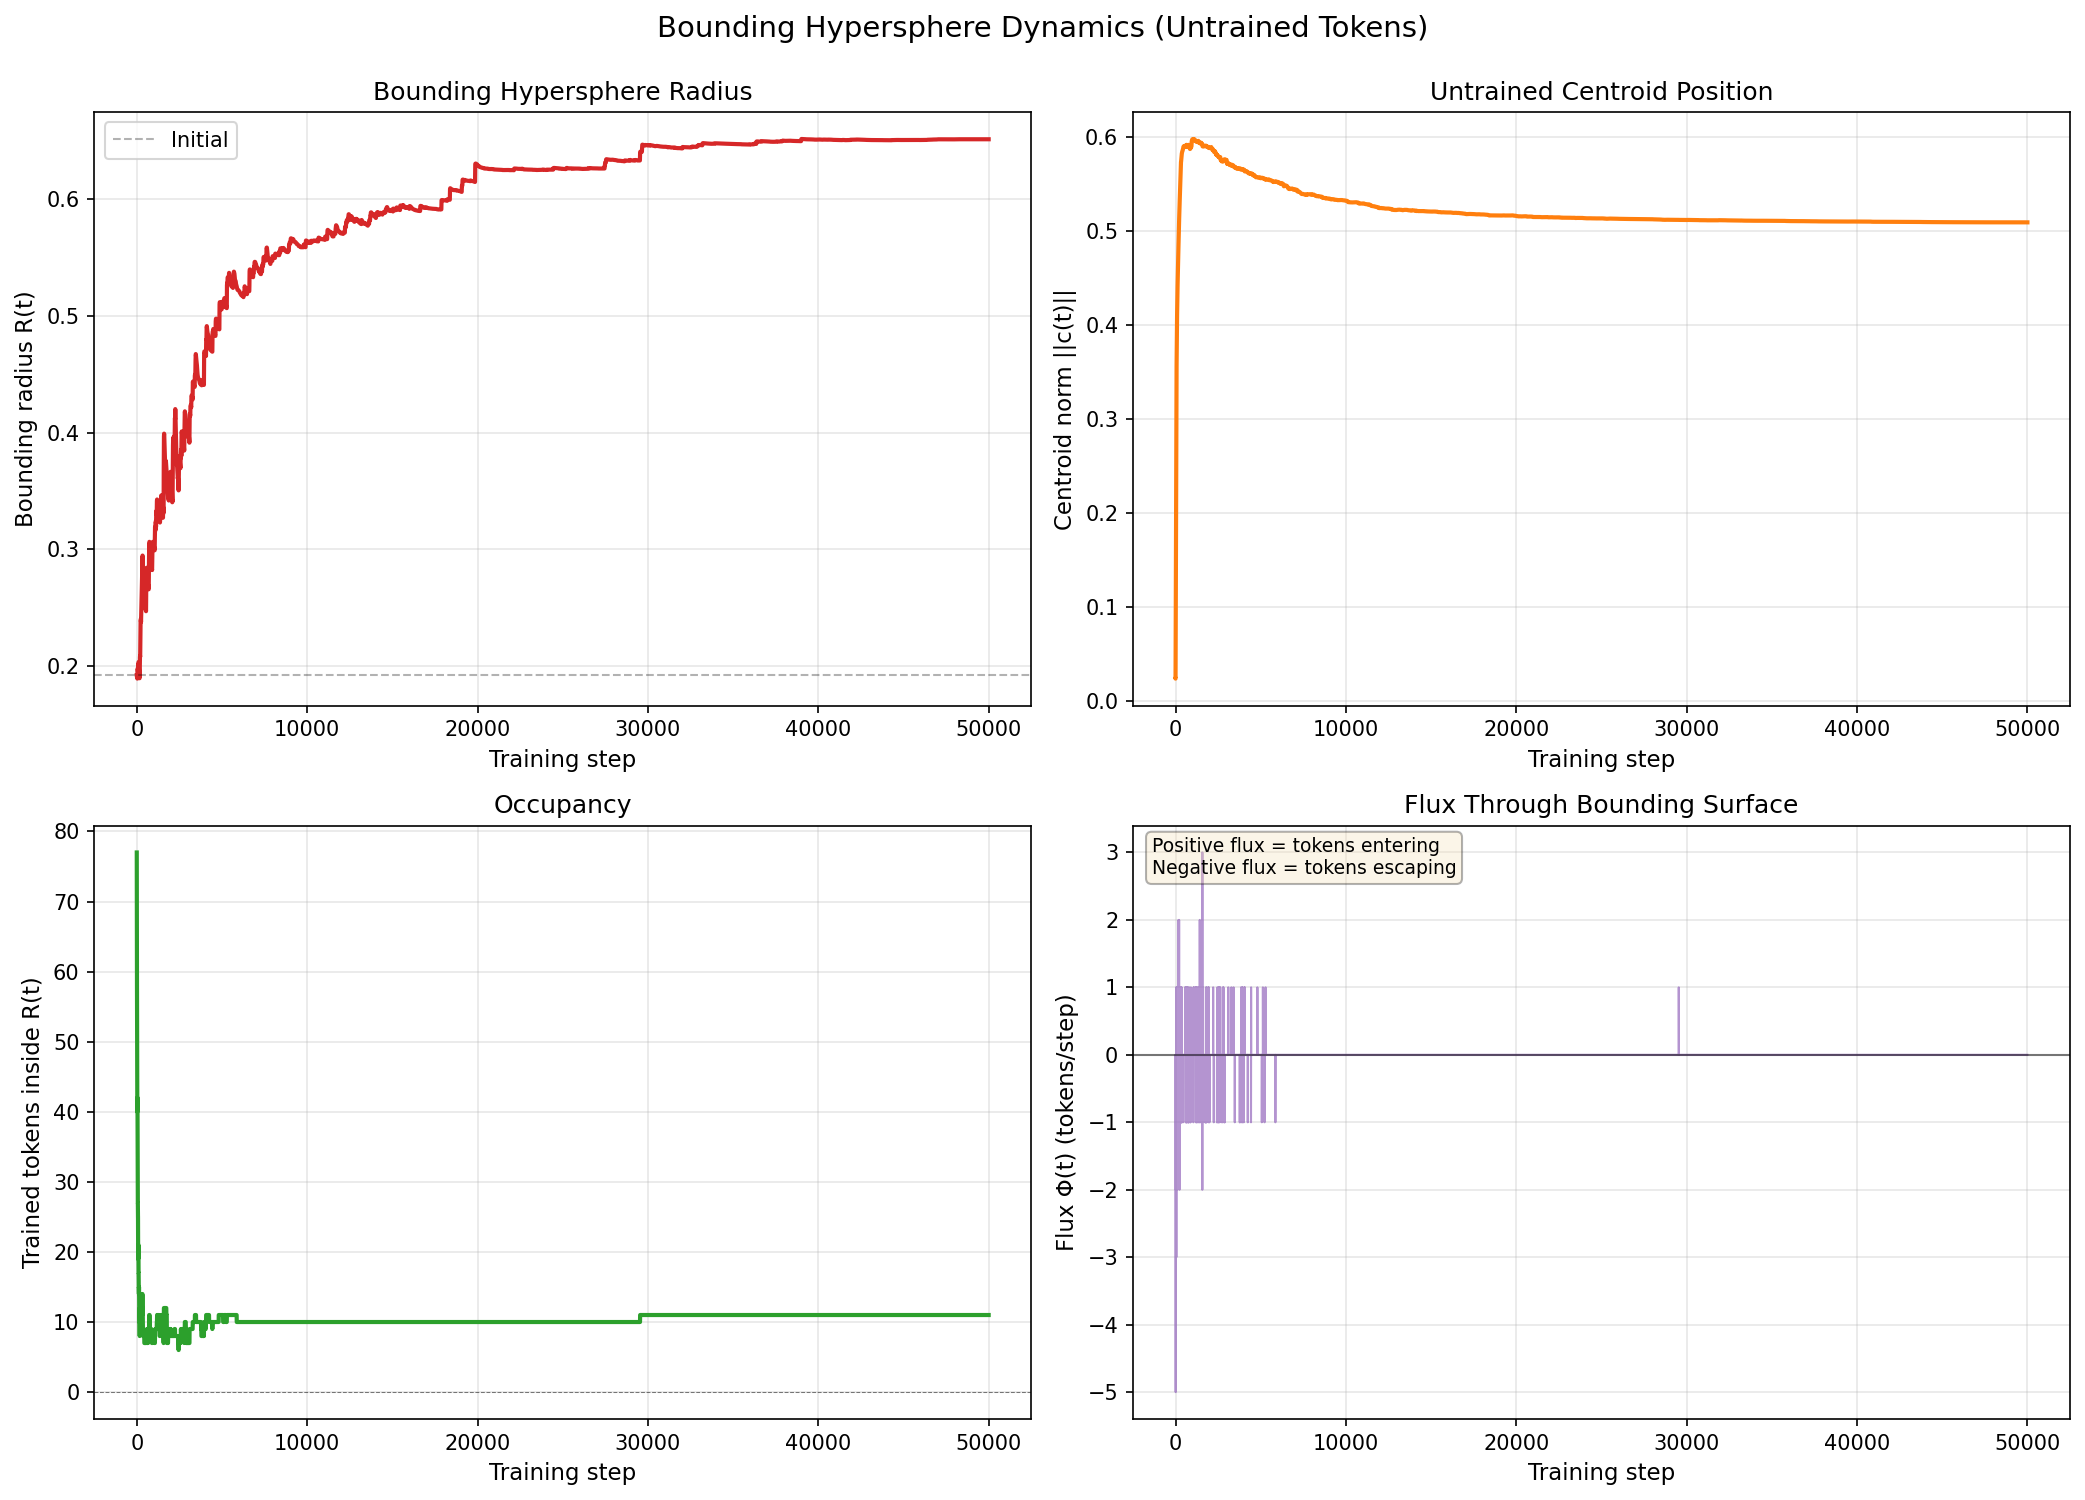

✓ Visualization complete


In [10]:
print(f"\nPlotting bounding hypersphere dynamics...\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=PLOT_DPI)

steps = np.arange(n_steps)

# Top left: Radius over time
ax = axes[0, 0]
ax.plot(steps, radii.numpy(), linewidth=2, color='#d62728')
ax.set_xlabel('Training step', fontsize=11)
ax.set_ylabel('Bounding radius R(t)', fontsize=11)
ax.set_title('Bounding Hypersphere Radius', fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(radii[0].item(), color='black', linewidth=1, linestyle='--', alpha=0.3, label='Initial')
ax.legend()

# Top right: Centroid position (norm)
ax = axes[0, 1]
ax.plot(steps, centroid_norms.numpy(), linewidth=2, color='#ff7f0e')
ax.set_xlabel('Training step', fontsize=11)
ax.set_ylabel('Centroid norm ||c(t)||', fontsize=11)
ax.set_title('Untrained Centroid Position', fontsize=12)
ax.grid(True, alpha=0.3)

# Bottom left: Trained tokens inside hypersphere
ax = axes[1, 0]
ax.plot(steps, n_inside.numpy(), linewidth=2, color='#2ca02c')
ax.set_xlabel('Training step', fontsize=11)
ax.set_ylabel('Trained tokens inside R(t)', fontsize=11)
ax.set_title('Occupancy', fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)

# Bottom right: Flux (change in count)
ax = axes[1, 1]
ax.plot(steps[:-1], flux.numpy(), linewidth=1, color='#9467bd', alpha=0.7)
ax.axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
ax.set_xlabel('Training step', fontsize=11)
ax.set_ylabel('Flux Φ(t) (tokens/step)', fontsize=11)
ax.set_title('Flux Through Bounding Surface', fontsize=12)
ax.grid(True, alpha=0.3)

# Add text annotations
ax.text(0.02, 0.98, f'Positive flux = tokens entering\nNegative flux = tokens escaping', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Bounding Hypersphere Dynamics (Untrained Tokens)', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print(f"✓ Visualization complete")

## Analysis: Is Structure Formation Happening?

In [11]:
print(f"\n{'='*80}")
print(f"STRUCTURE FORMATION ANALYSIS")
print(f"{'='*80}\n")

# 1. Radius evolution
radius_change = radii[-1] - radii[0]
radius_pct_change = 100 * radius_change / radii[0]

print(f"1. Bounding Radius:")
print(f"   Initial: {radii[0]:.6f}")
print(f"   Final: {radii[-1]:.6f}")
print(f"   Change: {radius_change:.6f} ({radius_pct_change:+.1f}%)")

if abs(radius_change) < 0.001:
    print(f"   → STABLE (no significant change)")
elif radius_change < 0:
    print(f"   → CONTRACTING (tokens converging!)")
    print(f"   → This could be a precursor to structure formation")
else:
    print(f"   → EXPANDING (tokens spreading apart)")
    print(f"   → No evidence of convergence")

print()

# 2. Flux analysis
total_outflow = (flux < 0).sum().item()
total_inflow = (flux > 0).sum().item()
net_flow = (n_inside[-1] - n_inside[0]).item()

print(f"2. Flux Through Boundary:")
print(f"   Initial occupancy: {n_inside[0]} trained tokens inside")
print(f"   Final occupancy: {n_inside[-1]} trained tokens inside")
print(f"   Net change: {net_flow:+d} tokens")
print(f"   Outflow events: {total_outflow} ({100*total_outflow/(n_steps-1):.1f}% of steps)")
print(f"   Inflow events: {total_inflow} ({100*total_inflow/(n_steps-1):.1f}% of steps)")

if net_flow < 0:
    print(f"   → NET OUTFLOW (trained tokens escaping untrained region)")
    print(f"   → This is expected behavior")
elif net_flow > 0:
    print(f"   → NET INFLOW (trained tokens entering untrained region!)")
    print(f"   → This is unusual and worth investigating")
else:
    print(f"   → EQUILIBRIUM (no net flow)")

print()

# 3. Clustering
print(f"3. Clustering (Fragmentation):")
if clustering_results:
    for step, result in clustering_results.items():
        print(f"   Step {step}: best k = {result['best_k']}, score = {result['best_score']:.4f}")
    
    # Check if k>1 ever wins
    fragmented = any(r['best_k'] > 1 for r in clustering_results.values())
    
    if fragmented:
        print(f"   → FRAGMENTATION DETECTED (k > 1 has better clustering)")
        print(f"   → Untrained tokens are splitting into groups!")
    else:
        print(f"   → NO FRAGMENTATION (k = 1 always best or tied)")
        print(f"   → Untrained tokens stay as one cluster")
else:
    print(f"   Not enough tokens for clustering analysis")

print()
print(f"{'='*80}")


STRUCTURE FORMATION ANALYSIS

1. Bounding Radius:
   Initial: 0.191929
   Final: 0.651573
   Change: 0.459644 (+239.5%)
   → EXPANDING (tokens spreading apart)
   → No evidence of convergence

2. Flux Through Boundary:
   Initial occupancy: 77 trained tokens inside
   Final occupancy: 11 trained tokens inside
   Net change: -66 tokens
   Outflow events: 120 (0.2% of steps)
   Inflow events: 73 (0.1% of steps)
   → NET OUTFLOW (trained tokens escaping untrained region)
   → This is expected behavior

3. Clustering (Fragmentation):
   Step 0: best k = 2, score = 0.0288
   Step 100: best k = 2, score = 0.0310
   Step 1000: best k = 2, score = 0.4132
   Step 5000: best k = 2, score = 0.4997
   Step 50000: best k = 2, score = 0.5996
   → FRAGMENTATION DETECTED (k > 1 has better clustering)
   → Untrained tokens are splitting into groups!



## Summary

In [12]:
print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}\n")
print(f"Analyzed: {TRAINING_DATA_PATH}")
print(f"  Tokens: {len(trained_tokens)} trained, {len(untrained_tokens)} untrained")
print(f"  Steps: {n_steps:,}")
print()
print(f"Key findings:")
print(f"  1. Radius change: {radius_change:.6f} ({radius_pct_change:+.1f}%)")
print(f"  2. Net flux: {net_flow:+d} trained tokens")
if clustering_results:
    max_k = max(r['best_k'] for r in clustering_results.values())
    print(f"  3. Max fragmentation: k = {max_k}")
print()
print(f"Interpretation:")
if radius_change < -0.01 or (clustering_results and max_k > 1):
    print(f"  ⚠️  EVIDENCE FOR STRUCTURE FORMATION")
    print(f"  Untrained tokens show signs of convergence or fragmentation")
    print(f"  This is worth investigating further!")
else:
    print(f"  ✓ NO EVIDENCE FOR STRUCTURE FORMATION (as expected for control)")
    print(f"  Untrained tokens remain dispersed throughout training")
    print(f"  This confirms that default initialization doesn't produce spongecrystal")
print()
print(f"{'='*80}")


SUMMARY

Analyzed: ../tensors/Lil_Gatsby/1.12a_training_data_default_init_50000.safetensors
  Tokens: 79 trained, 49 untrained
  Steps: 50,001

Key findings:
  1. Radius change: 0.459644 (+239.5%)
  2. Net flux: -66 trained tokens
  3. Max fragmentation: k = 2

Interpretation:
  ⚠️  EVIDENCE FOR STRUCTURE FORMATION
  Untrained tokens show signs of convergence or fragmentation
  This is worth investigating further!

